# Introduction

In this lab, we will learn how to use Scikit-Learn's IterativeImputer class to impute missing values in a dataset. We will compare different estimators to see which one is best for the IterativeImputer when using a BayesianRidge estimator on the California housing dataset with a single value randomly removed from each row.

# Import Libraries

We will first import the necessary libraries for this lab.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.experimental import enable_iterative_imputer
from sklearn.datasets import fetch_california_housing
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.kernel_approximation import Nystroem
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

# Load Dataset

We will load the California housing dataset from Scikit-Learn. We will only use 2k samples to reduce the computational time.

In [3]:
N_SPLITS = 5

rng = np.random.RandomState(0)

X_full, y_full = fetch_california_housing(return_X_y=True)
X_full = X_full[::10]
y_full = y_full[::10]
n_samples, n_features = X_full.shape

In [16]:
# Baseline model performance on the full data without any missing values
estimator = BayesianRidge()
score_full_data = pd.DataFrame()
score_full_data["BayesianRidge"] = cross_val_score(
    estimator, X_full, y_full, scoring="neg_mean_squared_error", cv=N_SPLITS
)
score_full_data

,BayesianRidge
0,-0.408433
1,-0.636009
2,-0.614910
3,-1.089616
4,-0.407541


# Add Missing Values

We will add a single missing value to each row of the dataset.

In [7]:
X_missing = X_full.copy()
y_missing = y_full
missing_samples = np.arange(n_samples)
missing_features = rng.choice(n_features, n_samples, replace=True)
X_missing[missing_samples, missing_features] = np.nan

Adding missing values to a dataset is typically done for testing and experimentation purposes. It allows researchers and data scientists to evaluate how different imputation methods handle missing data, assess the robustness of machine learning models, and understand the impact of missing values on analysis and predictions. This practice helps in developing strategies to manage real-world datasets that often contain incomplete information.

# Impute Missing Values with Simple Imputer

We will use Scikit-Learn's SimpleImputer class to impute missing values using mean and median strategies.

In [10]:
score_simple_imputer = pd.DataFrame()
for strategy in ("mean", "median"):
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy=strategy), BayesianRidge()
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X_missing, y_missing, scoring="neg_mean_squared_error", cv=N_SPLITS
    )

score_simple_imputer

,mean,median
0,-0.592220,-0.606432
1,-0.744412,-0.743859
2,-0.781688,-0.774929
3,-1.226611,-1.211226
4,-0.664787,-0.707737


# Impute Missing Values with Iterative Imputer

We will use Scikit-Learn's **IterativeImputer** class to impute missing values using different estimators.

In [15]:
estimators = [
    BayesianRidge(),
    RandomForestRegressor(
        n_estimators=4,
        max_depth=10,
        bootstrap=True,
        max_samples=0.5,
        n_jobs=2,
        random_state=0,
    ),
    make_pipeline(
        Nystroem(kernel="polynomial", degree=2, random_state=0), Ridge(alpha=1e3)
    ),
    KNeighborsRegressor(n_neighbors=15),
]
score_iterative_imputer = pd.DataFrame()
tolerances = (1e-3, 1e-1, 1e-1, 1e-2)
for impute_estimator, tol in zip(estimators, tolerances):
    estimator = make_pipeline(
        IterativeImputer(
            random_state=0, estimator=impute_estimator, max_iter=25, tol=tol
        ),
        BayesianRidge(),
    )
    score_iterative_imputer[impute_estimator.__class__.__name__] = cross_val_score(
        estimator, X_missing, y_missing, scoring="neg_mean_squared_error", cv=N_SPLITS
    )

score_iterative_imputer

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,BayesianRidge,RandomForestRegressor,Pipeline,KNeighborsRegressor
0,-0.516986,-0.528015,-0.475720,-0.601761
1,-0.749338,-0.697155,-0.681034,-0.744538
2,-0.656458,-0.700494,-0.653568,-0.782995
3,-0.851698,-1.066303,-1.240664,-1.248985
4,-0.625168,-0.520285,-0.550648,-0.681261


The **IterativeImputer** class in Scikit-Learn is used for imputing missing values in a dataset using an iterative approach. It models each feature with missing values as a function of other features and uses a specified estimator (like **BayesianRidge**) to predict the missing values. The imputation process is performed iteratively, refining the estimates with each iteration until convergence is reached. This method is particularly useful for multivariate datasets, as it takes into account the relationships between features, leading to potentially more accurate imputations compared to simpler methods like mean or median imputation.

# Compare Results

We will compare the results of different imputation strategies using a bar chart.

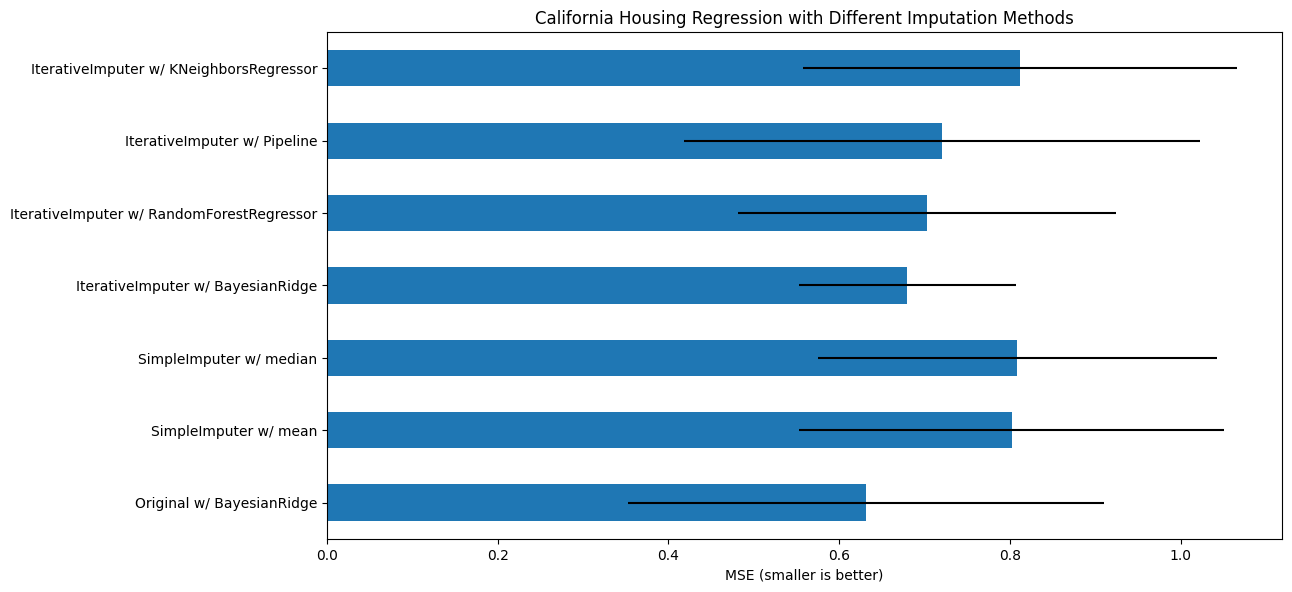

In [18]:
scores = pd.concat(
    [score_full_data, score_simple_imputer, score_iterative_imputer],
    keys = ['Original', 'SimpleImputer', 'IterativeImputer'],
    axis=1,
)

fig, ax = plt.subplots(figsize=(13, 6))
means = -scores.mean()
errors = scores.std()
means.plot.barh(xerr=errors, ax=ax)
ax.set_title('California Housing Regression with Different Imputation Methods')
ax.set_xlabel("MSE (smaller is better)")
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels([" w/ ".join(label) for label in means.index.tolist()])
plt.tight_layout(pad=1)
plt.show()


- IterativeImputer methods generally outperform SimpleImputer, especially those using models like BayesianRidge or RandomForest.

- The "Original" model still performs best, showing that missing data hurts performance no matter how well it's imputed.

- The error bars tell you how consistent the model is — shorter bars are more stable across CV splits.

# Summary

In this lab, we learned how to use Scikit-Learn's **IterativeImputer** class to impute missing values in a dataset. We compared different imputation strategies using mean and median imputation with **SimpleImputer** and different estimators with **IterativeImputer**. We found that **BayesianRidge** and **RandomForestRegressor** gave the best results for this particular pattern of missing values in the California housing dataset.